# 1 Setting up Spark NLP

In [1]:
# Mount google drive
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# Install Java
#!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark
#if os.path.isfile("./spark-3.5.1-bin-hadoop3.tgz") == False:
#    !wget -q https://downloads.apache.org/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz

# Unzip the file
#!tar xf spark-3.5.1-bin-hadoop3.tgz

# Setup environment for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/home/ubuntu/spark-3.5.1-bin-hadoop3'

# Import findspark and load it
#!pip install -q findspark
import findspark
findspark.init()

# import spacy for NLP and re for regular expressions
import spacy
spacy.cli.download("en_core_web_sm")
import en_core_web_sm
from spacy.lang.en.stop_words import STOP_WORDS
import re

# Install spark-nlp
#!pip install spark-nlp
import sparknlp
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.common import *
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.window import Window
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, OneHotEncoder, StringIndexer
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel, TrainValidationSplit, TrainValidationSplitModel
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.linalg import Vectors, VectorUDT
import pyspark.pandas as ps

# Create Spark session
#from pyspark.sql import SparkSession
#spark = SparkSession.builder\
#        .master("local")\
#        .appName("Spark NLP")\
#        .config('spark.executor.memory', "24g")\
#        .getOrCreate()

# Create Spark session with GPU and large memory 24G
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("Spark NLP")\
    .master("local[*]")\
    .config("spark.driver.memory","24G")\
    .config("spark.driver.maxResultSize", "0") \
    .config("spark.kryoserializer.buffer.max", "2000M")\
    .config("spark.jars.packages", "com.johnsnowlabs.nlp:spark-nlp-gpu_2.12:5.3.1")\
    .getOrCreate()

# Start Spark Session with Spark NLP
#spark = sparknlp.start(gpu=True)
#spark = sparknlp.start(gpu=False)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 92.3 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


/home/ubuntu/spark-3.5.1-bin-hadoop3/python/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


:: loading settings :: url = jar:file:/home/ubuntu/spark-3.5.1-bin-hadoop3/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/ubuntu/.ivy2/cache
The jars for the packages stored in: /home/ubuntu/.ivy2/jars
com.johnsnowlabs.nlp#spark-nlp-gpu_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-9c6cb42b-8717-4941-b5e2-ff4a9a920f00;1.0
	confs: [default]
	found com.johnsnowlabs.nlp#spark-nlp-gpu_2.12;5.3.1 in central
	found com.typesafe#config;1.4.2 in central
	found org.rocksdb#rocksdbjni;6.29.5 in central
	found com.amazonaws#aws-java-sdk-s3;1.12.500 in central
	found com.amazonaws#aws-java-sdk-kms;1.12.500 in central
	found com.amazonaws#aws-java-sdk-core;1.12.500 in central
	found commons-logging#commons-logging;1.1.3 in central
	found commons-codec#commons-codec;1.15 in central
	found org.apache.httpcomponents#httpclient;4.5.13 in central
	found org.apache.httpcomponents#httpcore;4.4.13 in central
	found software.amazon.ion#ion-java;1.0.2 in central
	found joda-time#joda-time;2.8.1 in central
	found com.amazonaws#jmespath-java;1.12.500 i

In [3]:
spark

# 2 Import libraries

In [4]:
import time
import json
import pickle
import urllib.request
# import altair as alt
import pandas as pd
import collections

In [5]:
# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image, display, HTML
import pydot
from pydotplus import graph_from_dot_data
from wordcloud import WordCloud

In [6]:
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import ElementTree
import datetime

In [7]:
# sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn import tree
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, zero_one_loss, classification_report, fbeta_score
from sklearn.utils import resample

In [8]:
import nltk
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from transformers import AutoTokenizer, BertTokenizer
from transformers import TFAutoModelForSequenceClassification, TFBertModel
from datasets import Dataset, DatasetDict
from datasets import ClassLabel, Value, Features
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2024-03-30 18:35:20.871880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-30 18:35:20.871932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-30 18:35:20.872788: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-30 18:35:20.879031: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-30 18:35:21.582415: W tensorflow/compiler/tf2

Num GPUs Available:  1


In [9]:
import torch
print("Pytorch CUDA Available =", torch.cuda.is_available())
print("Pytorch CUDA Device Count =", torch.cuda.device_count())
print("Pytorch CUDA Current Device =", torch.cuda.current_device())
print("Pytorch CUDA Current Device Name =", torch.cuda.get_device_name(torch.cuda.current_device()))

Pytorch CUDA Available = True
Pytorch CUDA Device Count = 1
Pytorch CUDA Current Device = 0
Pytorch CUDA Current Device Name = NVIDIA A10G


# 3 Load data

### 3.1 Obtain training and test datasets

In [10]:
# train_merged_data_conversations_path = 's3a://capstone210/data/train_merged_data_conversations/'
# test_merged_data_conversations_path = 's3a://capstone210/data/test_merged_data_conversations/'

# train_merged_data_conversations_df = spark.read.parquet(train_merged_data_conversations_path)
# test_merged_data_conversations_df = spark.read.parquet(test_merged_data_conversations_path)

In [11]:
train_data_path = 's3a://capstone210/data/final/train/'
test_data_path = 's3a://capstone210/data/final/test/'

train_merged_data_conversations_df = spark.read.parquet(train_data_path)
test_merged_data_conversations_df = spark.read.parquet(test_data_path)

24/03/30 18:35:23 WARN MetricsConfig: Cannot locate configuration: tried hadoop-metrics2-s3a-file-system.properties,hadoop-metrics2.properties


In [12]:
#train_df_final = df.filter(col('source') != 'PAN12-test')
train_df_final = train_merged_data_conversations_df
test_df_final = test_merged_data_conversations_df

In [13]:
#train_df_final.take(1)

In [14]:
train_df_final.describe()

DataFrame[summary: string, conversation_id: string, source: string, label: string, conversation_start_time: string, n_people_in_conversation: string, type_conversation: string, merged_text: string, merged_text_id: string, n_texts: string]

In [15]:
train_df_final.count()

69111

In [16]:
train_df_final.groupBy('label')\
              .agg(count('*').alias('count'))\
              .show(truncate = False)

+-----+-----+
|label|count|
+-----+-----+
|1    |3119 |
|0    |65992|
+-----+-----+



In [17]:
#train_df_final.filter(col('label').isin([1])).show(truncate = True)

In [18]:
test_df_final.count()

156985

In [19]:
test_df_final.groupBy('label')\
             .agg(count('*').alias('count'))\
             .show(truncate = False)

+-----+------+
|label|count |
+-----+------+
|1    |3723  |
|0    |153262|
+-----+------+



# 4 Prepare Data before  BERT Tokenization


## 4.1 Convert to Pandas dataframe and show Statistics

In [20]:
train_df_pandas = train_df_final.select('merged_text','label').toPandas()

In [21]:
test_df_pandas = test_df_final.select('merged_text','label').toPandas()

In [22]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [23]:
train_df_pandas['num_char'] = train_df_pandas['merged_text'].apply(len)
train_df_pandas['num_words'] = train_df_pandas['merged_text'].apply(lambda x: len(nltk.word_tokenize(x)))
train_df_pandas['num_sent'] = train_df_pandas['merged_text'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [24]:
print("Summary of each field when category is non-grooming:")
train_df_pandas[train_df_pandas['label']==0][['num_char', 'num_words', 'num_sent']].describe()

Summary of each field when category is non-grooming:


,num_char,num_words,num_sent
count,65992.000000,65992.000000,65992.000000
mean,510.916353,109.291263,5.619469
std,3715.143582,752.685795,62.950295
min,1.000000,1.000000,1.000000
25%,26.000000,8.000000,1.000000
50%,65.000000,16.000000,2.000000
75%,346.000000,76.000000,4.000000
max,773529.000000,165703.000000,11996.000000


In [25]:
print("Summary of each field when category is grooming:")
train_df_pandas[train_df_pandas['label']==1][['num_char', 'num_words', 'num_sent']].describe()

Summary of each field when category is grooming:


,num_char,num_words,num_sent
count,3119.000000,3119.000000,3119.000000
mean,467.827188,114.030138,4.906060
std,833.115071,200.483592,9.525454
min,1.000000,1.000000,1.000000
25%,27.000000,7.000000,1.000000
50%,123.000000,31.000000,1.000000
75%,595.500000,146.000000,5.000000
max,11867.000000,2696.000000,217.000000


Histogram of Number of Words by Category:


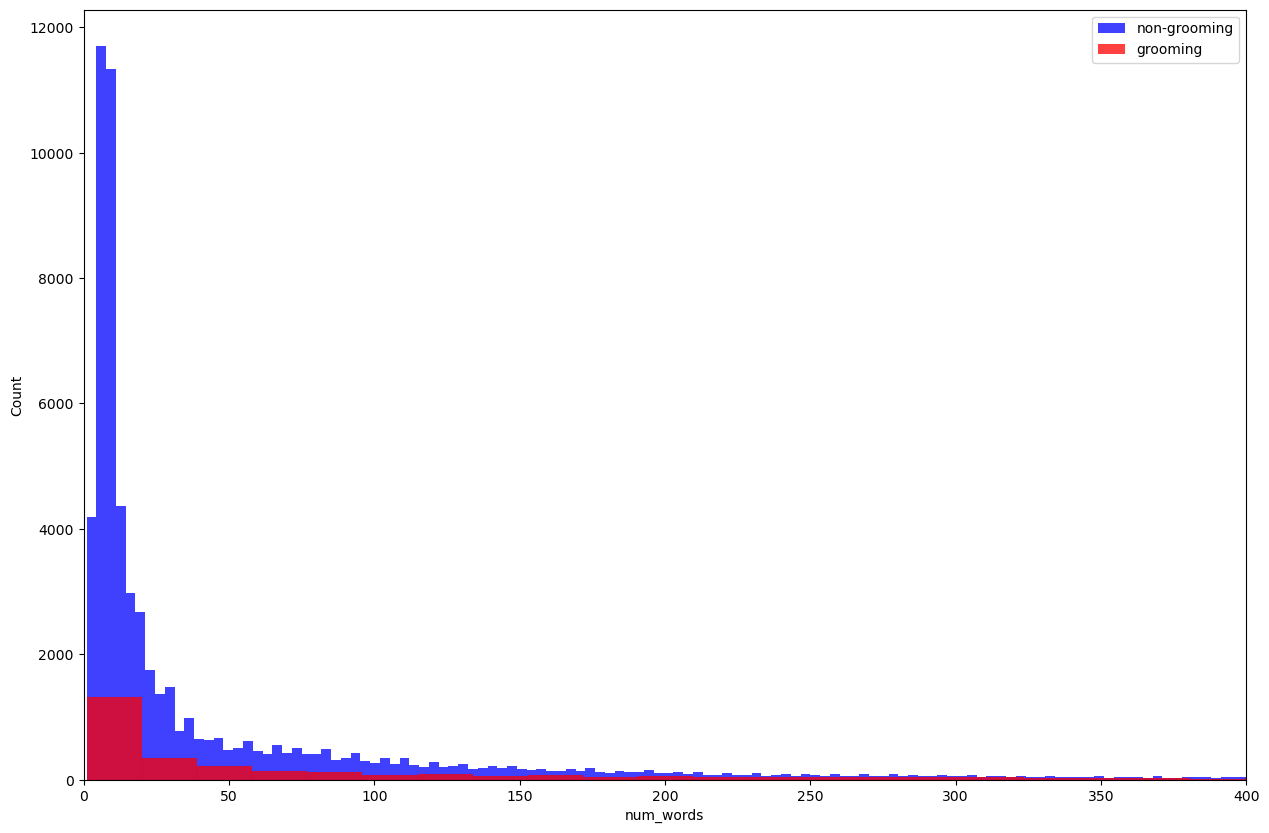

In [26]:
print("Histogram of Number of Words by Category:")
fig, ax = plt.subplots(figsize=(15,10))
sns.histplot(train_df_pandas[train_df_pandas['label']==0]['num_words'], color='blue')
sns.histplot(train_df_pandas[train_df_pandas['label']==1]['num_words'], color='red')
ax.set_xlim(0,400)
plt.legend(labels=['non-grooming', 'grooming'])
plt.show()

## 4.2 Stratified Split into Train and Validation before doing Resample to avoid Leakage

In [27]:
# 5% for validation
df_pd_train_split, df_pd_val_final = train_test_split(
    train_df_pandas[['merged_text','label']], test_size=0.05, stratify=train_df_pandas["label"].values, random_state=42
)

In [28]:
df_pd_train_split.count()

merged_text    65655
label          65655
dtype: int64

In [29]:
df_pd_train_split['label'].value_counts()

label
0    62692
1     2963
Name: count, dtype: int64

In [30]:
df_pd_val_final.count()

merged_text    3456
label          3456
dtype: int64

In [31]:
df_pd_val_final['label'].value_counts()

label
0    3300
1     156
Name: count, dtype: int64

In [32]:
try_df = df_pd_train_split[df_pd_train_split['label'] == 1]

In [33]:
### function to oversample and undersample dataset automatically
### resample_method = ['both', 'oversample', 'undersample']
def resample(df, outcome_col, major_downsample_ratio=0.50, minor_upsample_ratio=0.50, seed=1234, resample_method='both', make_equal=1):
    # Split dataset based on outcome
    split0_df = df[df[outcome_col] == 0]
    split1_df = df[df[outcome_col] == 1]
    # determine which split is major vs minor
    if (len(split0_df) > len(split1_df)):
        major_df = split0_df
        minor_df = split1_df
    else:
        minor_df = split0_df
        major_df = split1_df
    # upsample minor from ratio
    if (resample_method == 'both' or resample_method =='oversample'):
        if (minor_upsample_ratio != 0.0):
            print("Perform oversampling technique with ratio =", minor_upsample_ratio)
            added_minor_df = minor_df.sample(replace=False, frac=minor_upsample_ratio, random_state=seed)
            minor_df = pd.concat([minor_df,added_minor_df], axis=0)
    # calculate ratio    
    ratio = len(major_df)/len(minor_df)
    print("Ratio of major vs minor before sampling: {}".format(ratio))
    if (resample_method == 'both' or resample_method =='undersample'):
        # Start under-sampling with Spark
        if (make_equal == 1):
            print("Perform underampling technique with ratio =", 1/ratio)
            sampled_majority_df = major_df.sample(replace=False, frac=1/ratio, random_state=seed)
        else:
            print("Perform underampling technique with ratio =", major_downsample_ratio)
            sampled_majority_df = major_df.sample(replace=False, frac=major_downsample_ratio, random_state=seed)
        major_df = sampled_majority_df
    combined_df = pd.concat([major_df,minor_df], axis=0)
    # shuffle the DataFrame rows
    combined_df = combined_df.sample(frac = 1)
    print(f"Final sample size: {combined_df.count()}")
    return combined_df

Perform oversampling technique with ratio = 0.75
Ratio of major vs minor before sampling: 12.09103182256509
Perform underampling technique with ratio = 0.25
Final sample size: merged_text    20858
label          20858
dtype: int64


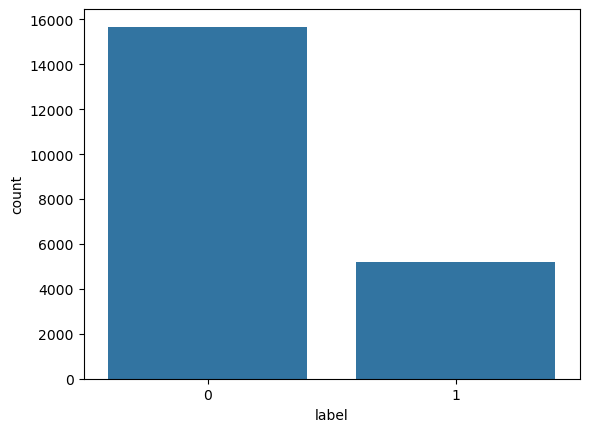

In [183]:
# Perform resampling technique
df_pd_train_final = resample(df_pd_train_split, outcome_col='label', major_downsample_ratio=0.25, minor_upsample_ratio=0.75, resample_method='both', make_equal=0)
df_pandas = df_pd_train_final[['label']]
ax = sns.countplot(x="label",data=df_pandas)

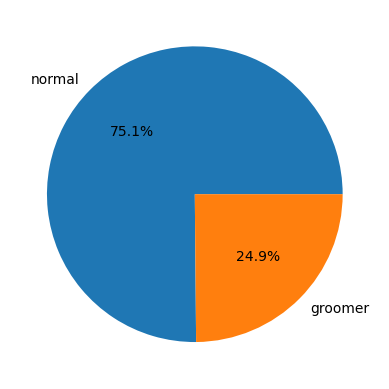

In [184]:
plt.pie(df_pandas["label"].value_counts(), labels=['normal','groomer'], autopct='%1.1f%%')
plt.show()

# 5 Model Building: Tensorflow BERT Pretrained Model

## 5.1 Download Tensorflow BERT Pretrained English language model for transferred-learning/fine-tuning

In [185]:
# Select a BERT Base cased pretrained model
#model_checkpoint = "bert-base-cased"
model_checkpoint = "bert-base-uncased"
#model_checkpoint = "ydshieh/bert-base-uncased-yelp-polarity"

In [186]:
# use the AutoTokenizer object to avoid simple configuration mistakes 
# because it insures that we get the correct tokenizer given our pre-trained model.

#tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer = BertTokenizer.from_pretrained(model_checkpoint)

In [187]:
# Testing the tokenizer 
tokenizer("Hello, we only need one sentence for our task but these reviews often have more.")

{'input_ids': [101, 7592, 1010, 2057, 2069, 2342, 2028, 6251, 2005, 2256, 4708, 2021, 2122, 4391, 2411, 2031, 2062, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [188]:
#model = TFAutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2) # 2 classes for 0 and 1
model = TFBertModel.from_pretrained(model_checkpoint)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

### First understand this pretrained model

In [189]:
bert_input = tokenizer(['This is great!', 
                        'This is terrible!'],
              max_length=10,
              truncation=True,
              padding='max_length',
              return_tensors='tf')

bert_input

{'input_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[ 101, 2023, 2003, 2307,  999,  102,    0,    0,    0,    0],
       [ 101, 2023, 2003, 6659,  999,  102,    0,    0,    0,    0]],
      dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 10), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 0, 0, 0, 0]], dtype=int32)>}

In [190]:
len(model.weights)

199

In [191]:
model.weights[0]

<tf.Variable 'tf_bert_model_1/bert/embeddings/word_embeddings/weight:0' shape=(30522, 768) dtype=float32, numpy=
array([[-0.01018257, -0.06154883, -0.02649689, ..., -0.01985357,
        -0.03720997, -0.00975152],
       [-0.01170495, -0.06002603, -0.03233192, ..., -0.01681456,
        -0.04009988, -0.0106634 ],
       [-0.01975381, -0.06273633, -0.03262176, ..., -0.01650258,
        -0.04198876, -0.00323178],
       ...,
       [-0.02176224, -0.0556396 , -0.01346345, ..., -0.00432698,
        -0.0151355 , -0.02489496],
       [-0.04617237, -0.05647721, -0.00192082, ...,  0.01568751,
        -0.01387033, -0.00945213],
       [ 0.00145601, -0.08208051, -0.01597912, ..., -0.00811687,
        -0.04746607,  0.07527421]], dtype=float32)>

In [192]:
model.weights[-1]

<tf.Variable 'tf_bert_model_1/bert/pooler/dense/bias:0' shape=(768,) dtype=float32, numpy=
array([-3.59758101e-02, -3.89536447e-03,  5.18135242e-02,  2.22474653e-02,
       -4.93722595e-03, -1.12034811e-03,  2.63389684e-02,  9.06389207e-03,
        3.87229286e-02, -9.65566933e-02,  2.33106632e-02, -2.00860817e-02,
        6.54901490e-02, -5.16800582e-02,  6.61561340e-02, -1.47210108e-02,
       -4.53246664e-03, -8.40590510e-04,  1.30266594e-02, -2.97703724e-02,
        4.36932743e-02, -1.42916441e-02,  4.54890691e-02,  4.53457702e-03,
        7.68589275e-03, -4.09257710e-02, -1.14115337e-02,  6.60372078e-02,
        6.73762187e-02,  4.28587943e-02, -2.69748904e-02,  3.52813004e-05,
       -8.14828426e-02, -3.75685841e-03,  4.05701660e-02, -5.76940365e-02,
       -8.32851697e-03, -2.62178238e-02, -4.79239225e-03, -8.22489429e-03,
       -6.46718442e-02,  1.95789011e-03,  7.20151439e-02, -2.25517321e-02,
        3.41102644e-03, -1.42510980e-02, -8.34877975e-03,  3.89568089e-03,
       -5

In [193]:
bert_output = model(bert_input)
bert_output

TFBaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=<tf.Tensor: shape=(2, 10, 768), dtype=float32, numpy=
array([[[ 0.09159239,  0.16384561,  0.04863737, ..., -0.1982761 ,
          0.1756119 ,  0.184982  ],
        [-0.80346376,  0.16796118,  0.28415877, ..., -0.8848038 ,
          0.2874537 ,  0.52153885],
        [-0.00689596, -0.03130595,  0.3222831 , ..., -0.19864035,
          0.32296324,  0.6851795 ],
        ...,
        [ 0.03410745, -0.27392352,  0.270483  , ...,  0.18396628,
          0.05372727, -0.30027002],
        [ 0.30243337,  0.03761856,  0.4375779 , ..., -0.05095244,
          0.03641126, -0.16423072],
        [-0.04681697, -0.38299164,  0.24613684, ...,  0.18162245,
          0.0209226 , -0.37885362]],

       [[ 0.11298604,  0.5107682 , -0.16759236, ..., -0.24840526,
          0.24137571,  0.36224416],
        [-0.21236224,  0.55142224, -0.04688253, ..., -0.6848279 ,
          0.94448817,  0.41532332],
        [ 0.44161803,  0.2328135 ,  0.13136236, ..

## 5.2 Tokenize Inputs and prepare Tensorflow Train and Test Datasets

In [194]:
df_pd_train = df_pd_train_final

In [195]:
df_pd_val = df_pd_val_final

In [196]:
df_pd_test = test_df_pandas

In [197]:
X_train = df_pd_train['merged_text']
y_train = df_pd_train['label']
X_val = df_pd_val['merged_text']
y_val = df_pd_val['label']
X_test = df_pd_test['merged_text']
y_test = df_pd_test['label']

In [198]:
X_train.head()

22643                              hi m or f hi m 20 india
69056    ya there? Hey bAby heyyy whatcha up to Nothing...
68941    hiiiii Hey baby where u been gma picked me up ...
18253    I miss you too, where are you?? u never called...
66770            asl IM BLACK HATERS GON&apos; HATE FUCK U
Name: merged_text, dtype: object

In [199]:
y_train.head()

22643    0
69056    1
68941    1
18253    1
66770    0
Name: label, dtype: int32

In [200]:
X_train.count()

20858

In [201]:
X_val.count()

3456

In [203]:
MAX_SEQUENCE_LENGTH = 400                 # set max_length of the input sequence

In [204]:
#@title BERT Tokenization of training and test data
bert_train_tokenized = tokenizer(X_train.tolist(),
                                      max_length=MAX_SEQUENCE_LENGTH,
                                      truncation=True,
                                      padding='max_length',
                                      return_tensors='tf')
bert_train_inputs = [bert_train_tokenized.input_ids,
                     bert_train_tokenized.token_type_ids,
                     bert_train_tokenized.attention_mask]
bert_train_labels = np.array(y_train)

bert_val_tokenized = tokenizer(X_val.tolist(),
                                      max_length=MAX_SEQUENCE_LENGTH,
                                      truncation=True,
                                      padding='max_length',
                                      return_tensors='tf')
bert_val_inputs = [bert_val_tokenized.input_ids,
                   bert_val_tokenized.token_type_ids,
                   bert_val_tokenized.attention_mask]
bert_val_labels = np.array(y_val)

bert_test_tokenized = tokenizer(X_test.tolist(),
                                     max_length=MAX_SEQUENCE_LENGTH,
                                     truncation=True,
                                     padding='max_length',
                                     return_tensors='tf')
bert_test_inputs = [bert_test_tokenized.input_ids,
                    bert_test_tokenized.token_type_ids,
                    bert_test_tokenized.attention_mask]
bert_test_labels = np.array(y_test)

In [205]:
bert_train_inputs

[<tf.Tensor: shape=(20858, 400), dtype=int32, numpy=
 array([[  101,  7632,  1049, ...,     0,     0,     0],
        [  101,  8038,  2045, ...,     0,     0,     0],
        [  101,  7632, 28954, ...,     0,     0,     0],
        ...,
        [  101,  2534,  2080, ...,     0,     0,     0],
        [  101,  7632,  2129, ...,     0,     0,     0],
        [  101,  2129,  2272, ...,     0,     0,     0]], dtype=int32)>,
 <tf.Tensor: shape=(20858, 400), dtype=int32, numpy=
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>,
 <tf.Tensor: shape=(20858, 400), dtype=int32, numpy=
 array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        ...,
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>]

In [206]:
print(len(bert_train_inputs[0]))
print(len(bert_val_inputs[0]))
print(len(bert_test_inputs[0]))

20858
3456
156985


## 5.3 Run Training Model

In [207]:
# Defining functions for different performance metrics
from keras import backend as K
from torchmetrics import FBetaScore
from torchmetrics.classification import BinaryFBetaScore

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    return true_positives / (predicted_positives + K.epsilon())

def f1(y_true, y_pred):
    precision_score_ = precision(y_true, y_pred)
    recall_score_ = recall(y_true, y_pred)
    return 2*((precision_score_*recall_score_)/(precision_score_+recall_score_+K.epsilon()))

def f3(y_true, y_pred):
    fb_metric = BinaryFBetaScore(beta=3.0)
    score = fb_metric(y_pred, y_true)
    return score[0].item()


In [208]:
def create_bert_classification_model(bert_model,
                                     num_train_layers=0,
                                     max_sequence_length=MAX_SEQUENCE_LENGTH,
                                     num_filters = [100, 100, 50, 25],
                                     kernel_sizes = [3, 4, 5, 10],
                                     hidden_size = 200,
                                     hidden2_size = 100,
                                     # hidden3_size = 128,
                                     dropout = 0.3,
                                     learning_rate = 0.001,
                                     label_smoothing = 0.03
                                    ):
    """
    Build a simple classification model with BERT. Use the Pooler Output or CLS for classification purposes
    """
    if num_train_layers == 0:
        # Freeze all layers of pre-trained BERT model
        bert_model.trainable = False

    elif num_train_layers == 12:
        # Train all layers of the BERT model
        bert_model.trainable = True

    else:
        # Restrict training to the num_train_layers outer transformer layers
        retrain_layers = []

        for retrain_layer_number in range(num_train_layers):

            layer_code = '_' + str(11 - retrain_layer_number)
            retrain_layers.append(layer_code)


        print('retrain layers: ', retrain_layers)

        for w in bert_model.weights:
            if not any([x in w.name for x in retrain_layers]):
                #print('freezing: ', w)
                w._trainable = False

    input_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='input_ids')
    token_type_ids = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='token_type_ids')
    attention_mask = tf.keras.layers.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype=tf.int64, name='attention_mask')
    
    bert_inputs = {'input_ids': input_ids,
                   'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    bert_out = bert_model(bert_inputs)

    pooler_token = bert_out[1]
    cls_token = bert_out[0][:, 0, :]
    bert_out_avg = tf.math.reduce_mean(bert_out[0], axis=1)
    #output_logits = bert_out["logits"]
    cnn_token = bert_out[0]

    conv_layers_for_all_kernel_sizes = []
    for kernel_size, filters in zip(kernel_sizes, num_filters):
        conv_layer = tf.keras.layers.Conv1D(filters=filters, kernel_size=kernel_size, activation='relu')(cnn_token)
        conv_layer = tf.keras.layers.GlobalMaxPooling1D()(conv_layer)
        conv_layers_for_all_kernel_sizes.append(conv_layer)

    conv_output = tf.keras.layers.concatenate(conv_layers_for_all_kernel_sizes, axis=1)

    # classification layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer')(conv_output)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    hidden = tf.keras.layers.Dense(hidden2_size, activation='relu', name='hidden_layer2')(hidden)
    hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    # hidden = tf.keras.layers.Dense(hidden3_size, activation='relu', name='hidden_layer3')(hidden)
    # hidden = tf.keras.layers.Dropout(dropout)(hidden)
    
    classification = tf.keras.layers.Dense(1, activation='sigmoid',name='classification_layer')(hidden)

    classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])

    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 # LOSS FUNCTION
                                 #loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                                 loss=tf.keras.losses.BinaryFocalCrossentropy(
                                   gamma=2.0, from_logits=False, apply_class_balancing=True, label_smoothing=label_smoothing
                                 ),
                                 #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 #loss=tf.keras.losses.CategoricalFocalCrossentropy(
                                 #   alpha=0.25,
                                 #   gamma=2.0,
                                 #   from_logits=False,
                                 #   label_smoothing=0.03,
                                 #   axis=-1,
                                 #   reduction="sum_over_batch_size",
                                 #   name="categorical_focal_crossentropy",
                                 #),
                                 # METRIC FUNCTIONS
                                 # metrics=['accuracy', 
                                 #   tf.keras.metrics.Precision(),
                                 #   tf.keras.metrics.Recall(),
                                 #   tf.keras.metrics.F1Score(average=None, threshold=None, name="f1_score", dtype=None)
                                 # ]
                                 metrics=['accuracy', precision, recall, f1]
                                 # run_eagerly=True
                                 )
    return classification_model

In [209]:
bert_classification_model = create_bert_classification_model(bert_model=model,
                                                             num_train_layers=0,
                                                             dropout = 0.1,
                                                             learning_rate = 0.001,
                                                             label_smoothing = 0.03
                                                            )

In [210]:
bert_classification_model.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 400)]                0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 400)]                0         []                            
                                                                                                  
 token_type_ids (InputLayer  [(None, 400)]                0         []                            
 )                                                                                                
                                                                                           

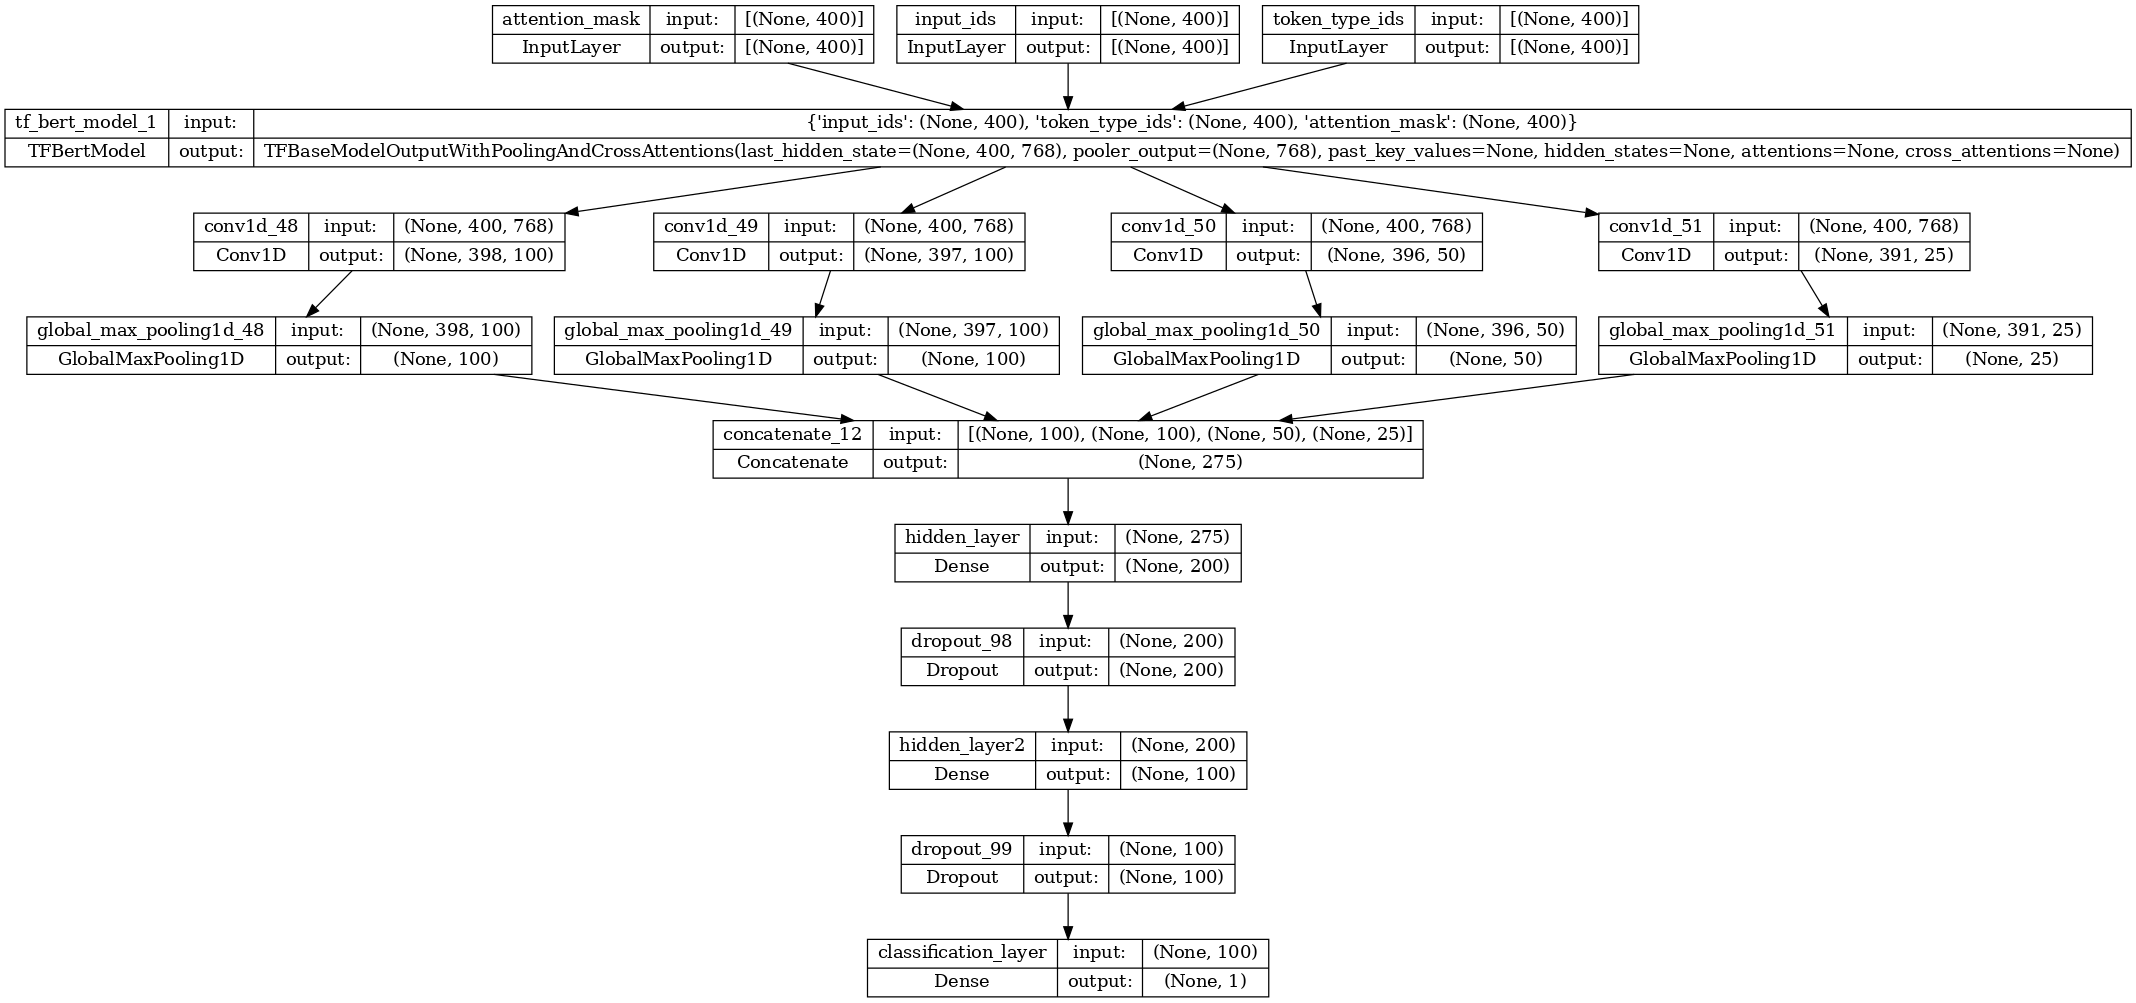

In [211]:
tf.keras.utils.plot_model(bert_classification_model, show_shapes=True, dpi=90)

In [212]:
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
print(os.getenv('TF_GPU_ALLOCATOR'))

cuda_malloc_async


In [213]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_recall', # Monitor validation loss
    min_delta=0.0005, # Minimum change to qualify as an improvement
    patience=8, # Number of epochs with no improvement after which training
    verbose=1,
    mode='max', # Stop training when the quantity monitored has stopped dec
    restore_best_weights=True # Restore model weights from the best epoch
)

# callbacks = keras.callbacks.ModelCheckpoint("childgrooming_NN_model_{epoch}.keras", save_best_only=True)
callbacks = tf.keras.callbacks.ModelCheckpoint(
    "basic_bert_cnn_weights.weights.h5",  # Filename for the saved weights
    save_best_only=True,  # Save only the best model
    save_weights_only=True,  # Save only the weights, not the full model
)

In [214]:
batch_size = 128
epochs = 100  # use early stopping

In [215]:
bert_history = bert_classification_model.fit(
                        bert_train_inputs,
                        bert_train_labels,
                        validation_data=(bert_val_inputs, bert_val_labels),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stopping, callbacks]
                        #callbacks=[callbacks]
)
    
# model.fit(train_tf_dataset, validation_data=test_tf_dataset, epochs=epochs)

Epoch 1/100
163/163 [==============================] - ETA: 0s - loss: 0.0309 - accuracy: 0.8914 - precision: 0.8476 - recall: 0.6653 - f1: 0.7250

/opt/conda/envs/pytorch/lib/python3.10/site-packages/transformers/generation/tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


163/163 [==============================] - 266s 2s/step - loss: 0.0309 - accuracy: 0.8914 - precision: 0.8476 - recall: 0.6653 - f1: 0.7250 - val_loss: 0.0113 - val_accuracy: 0.9644 - val_precision: 0.5712 - val_recall: 0.8646 - val_f1: 0.6634
Epoch 2/100
163/163 [==============================] - 248s 2s/step - loss: 0.0138 - accuracy: 0.9452 - precision: 0.9335 - recall: 0.8417 - f1: 0.8821 - val_loss: 0.0119 - val_accuracy: 0.9702 - val_precision: 0.6087 - val_recall: 0.9227 - val_f1: 0.7084
Epoch 3/100
163/163 [==============================] - 248s 2s/step - loss: 0.0117 - accuracy: 0.9506 - precision: 0.9428 - recall: 0.8535 - f1: 0.8906 - val_loss: 0.0120 - val_accuracy: 0.9685 - val_precision: 0.5934 - val_recall: 0.9486 - val_f1: 0.7040
Epoch 4/100
163/163 [==============================] - 251s 2s/step - loss: 0.0090 - accuracy: 0.9633 - precision: 0.9591 - recall: 0.8919 - f1: 0.9218 - val_loss: 0.0060 - val_accuracy: 0.9783 - val_precision: 0.7830 - val_recall: 0.7619 - val

## 5.4 Run against Validation Set

In [216]:
y_pred = bert_classification_model.predict(bert_val_inputs)

108/108 [==============================] - 31s 275ms/step


In [217]:
f_max = lambda x: np.argmax(x)

In [218]:
f_one_or_zero = lambda x: 1 if x > 0.5 else 0

In [219]:
val_y_pred = np.apply_along_axis(f_one_or_zero, 1, y_pred)

In [220]:
val_y_pred

array([0, 0, 1, ..., 0, 0, 0])

In [221]:
bert_val_labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int32)

In [222]:
# Calculate F_beta score with beta=3
f_beta3_score_test = fbeta_score(bert_val_labels, val_y_pred, average='binary', beta=3, pos_label=1)
print("F1 Score (w/ Beta =3):", f_beta3_score_test)

F1 Score (w/ Beta =3): 0.902654867256637


In [223]:
print(classification_report(bert_val_labels, val_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98      3300
           1       0.53      0.98      0.68       156

    accuracy                           0.96      3456
   macro avg       0.76      0.97      0.83      3456
weighted avg       0.98      0.96      0.96      3456



## 5.5 Run against Test Set

In [224]:
y_pred_ground_truth = bert_classification_model.predict(bert_test_inputs)

4906/4906 [==============================] - 1485s 302ms/step


In [225]:
test_y_pred = np.apply_along_axis(f_one_or_zero, 1, y_pred_ground_truth)

In [226]:
test_y_pred[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [227]:
bert_test_labels[:20]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
      dtype=int32)

In [228]:
# Calculate F_beta score with beta=3
f_beta3_score_test = fbeta_score(bert_test_labels, test_y_pred, average='binary', beta=3, pos_label=1)
print("F1 Score (w/ Beta =3):", f_beta3_score_test)

F1 Score (w/ Beta =3): 0.8280747847709305


In [229]:
print(classification_report(bert_test_labels, test_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98    153262
           1       0.39      0.95      0.55      3723

    accuracy                           0.96    156985
   macro avg       0.69      0.96      0.77    156985
weighted avg       0.98      0.96      0.97    156985



In [177]:
# Calculate F_beta score with beta=3
f_beta3_score_test = fbeta_score(bert_test_labels, test_y_pred, average='binary', beta=3, pos_label=1)
print("F1 Score (w/ Beta =3):", f_beta3_score_test)

F1 Score (w/ Beta =3): 0.7656225970164556


In [178]:
print(classification_report(bert_test_labels, test_y_pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99    153262
           1       0.54      0.80      0.65      3723

    accuracy                           0.98    156985
   macro avg       0.77      0.89      0.82    156985
weighted avg       0.98      0.98      0.98    156985



In [179]:
# import math

# def sigmoid(x):
#   return 1 / (1 + math.exp(-x))
# f_sigmoid_to_prediction = lambda x: 1 if sigmoid(x) > 0.5 else 0


In [180]:
#class_preds_truth = np.apply_along_axis(f_sigmoid_to_prediction, 1, y_pred_ground_truth["logits"])

In [181]:
# counter = collections.Counter(class_preds_truth)
# counter

# 6. Saving the entire Model and load it back

In [230]:
save_path = 'keras_model_h5/bert_cnn_ensemble_resample_uncased_mdl.h5'

In [231]:
bert_classification_model.save(save_path, save_format='h5')

/opt/conda/envs/pytorch/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [232]:
inference_model = create_bert_classification_model(bert_model=model,
                                                             num_train_layers=0,
                                                             dropout = 0.1,
                                                             learning_rate = 0.001,
                                                             label_smoothing = 0.03
                                                            )

In [233]:
inference_model.load_weights(save_path)

In [234]:
y_pred_inference = inference_model.predict(bert_val_inputs)

108/108 [==============================] - 31s 277ms/step


In [235]:
val_y_pred_inference = np.apply_along_axis(f_one_or_zero, 1, y_pred_inference)

In [236]:
# Calculate F_beta score with beta=3
f_beta3_score_test = fbeta_score(bert_val_labels, val_y_pred_inference, average='binary', beta=3, pos_label=1)
print("F1 Score (w/ Beta =3):", f_beta3_score_test)

F1 Score (w/ Beta =3): 0.902654867256637


In [1]:
# Free up GPU memory
# from numba import cuda 
# device = cuda.get_current_device()
# device.reset()